# Initial Trend Forecast Tests
### Andrew Attilio
### 09.22.2024

We ran the Trend Forecasting algorithm on the Monsoon HPC. 

Ran on one location: Arizona ('04') and 9 dates (before the SLURM job timed out). 

Settings for the TF algo included:
- 500 bootstrap samples
- Input time series: 50 previous days of beta values
- 5 weather covariates, no google search or movement yet

Runtime statistics:
- Each task (performing the forecast on a single date) took about 5.5 hours.
- Each task had access to 24 CPUs. 

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from src import paths


def plot_beta_forecast(pmcmc_data_file_path, ensemble_file_path):
    """
    Plots the beta forecast results.
    """
    date_str = path.basename(path.dirname(pmcmc_data_file_path))
    loc_str = path.splitext(path.basename(pmcmc_data_file_path))[0]

    beta_df = pd.read_csv(pmcmc_data_file_path)
    ensemble_df = pd.read_csv(ensemble_file_path)

    # Renaming columns for consistency
    beta_df["time_1"] = beta_df["time_0"] + 1
    beta_df.rename(columns={"time_1": "Day", "beta": "Beta"}, inplace=True)

    combined_df = pd.concat([beta_df, ensemble_df], ignore_index=True, sort=False)

    # Get the last beta value
    last_beta_day = beta_df["Day"].max()
    last_beta_value = beta_df.loc[beta_df["Day"] == last_beta_day, "Beta"].values[0]

    # Add the last beta value as the first point in ensemble_df for a smooth connection
    first_forecast_day = last_beta_day + 1
    ensemble_df = pd.concat(
        [
            pd.DataFrame(
                {
                    "Day": [last_beta_day],
                    "Mean": [last_beta_value],
                    "Lower": [last_beta_value],
                    "Upper": [last_beta_value],
                }
            ),
            ensemble_df,
        ],
        ignore_index=True,
    )

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        x="Day", y="Beta", data=beta_df, label="PMCMC Beta Estimation", color="blue"
    )
    sns.lineplot(
        x="Day",
        y="Mean",
        data=ensemble_df,
        label="Ensemble Mean Forecast",
        color="orange",
    )
    plt.fill_between(
        ensemble_df["Day"],
        ensemble_df["Lower"],
        ensemble_df["Upper"],
        color="gray",
        alpha=0.3,
        label="95% Prediction Interval",
    )

    # Add vertical dotted line at the prediction date
    prediction_day = beta_df["Day"].max()
    plt.axvline(
        x=prediction_day,
        color="black",
        linestyle="--",
        label=f"Prediction Start: {date_str}",
    )

    plt.title(f"Beta Ensemble Forecast for Loc {loc_str}: {date_str}")
    plt.xlabel("Day")
    plt.ylabel("Beta Value")
    plt.legend()

    plt.show()

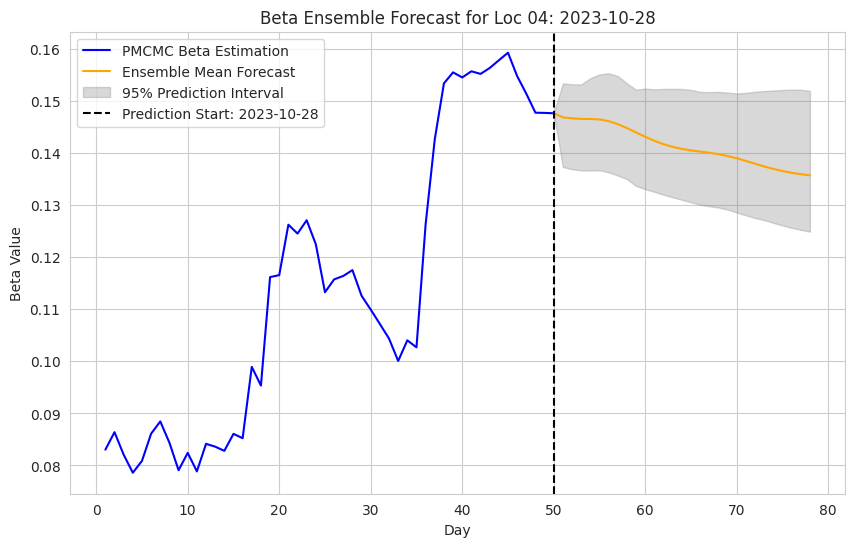

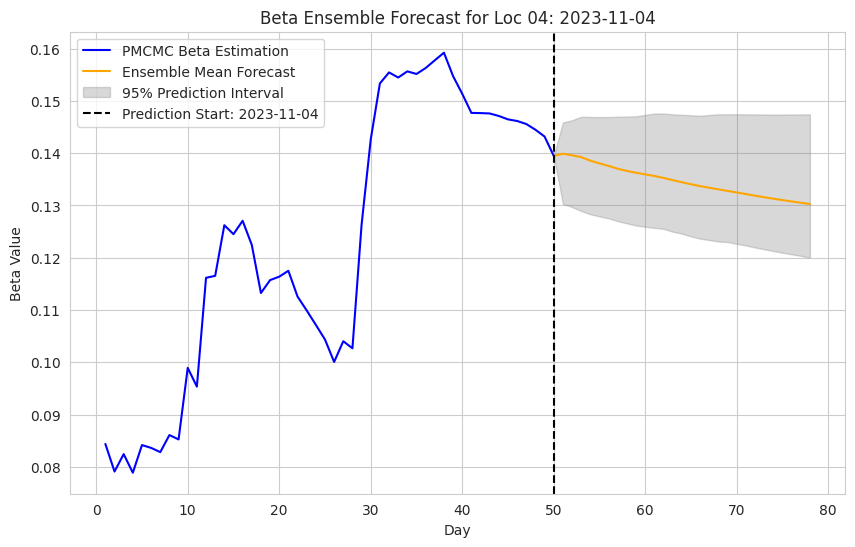

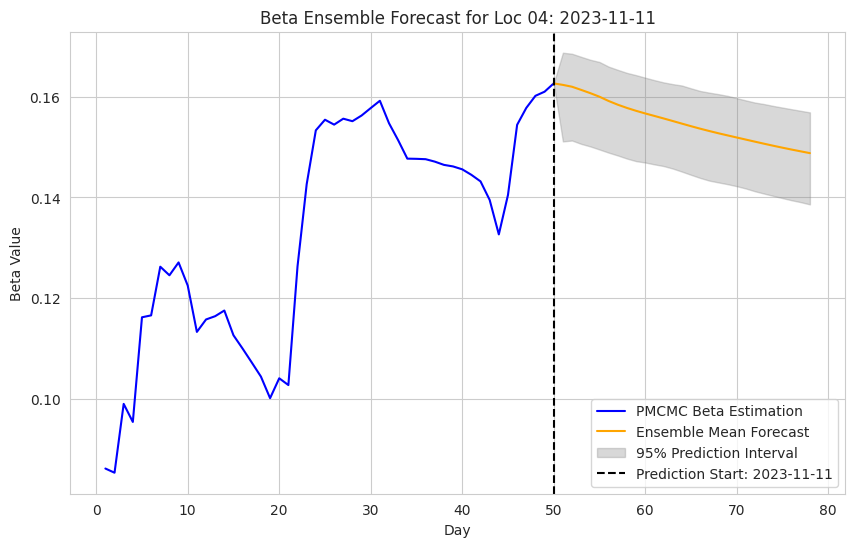

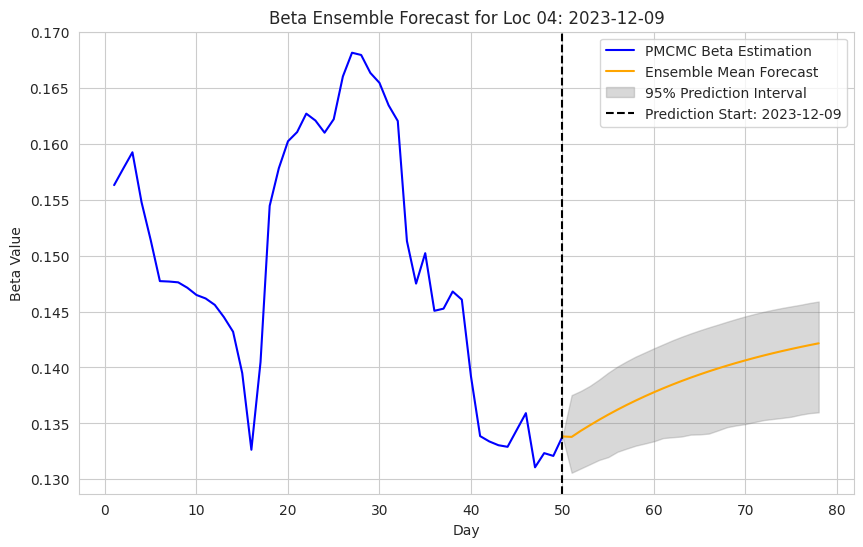

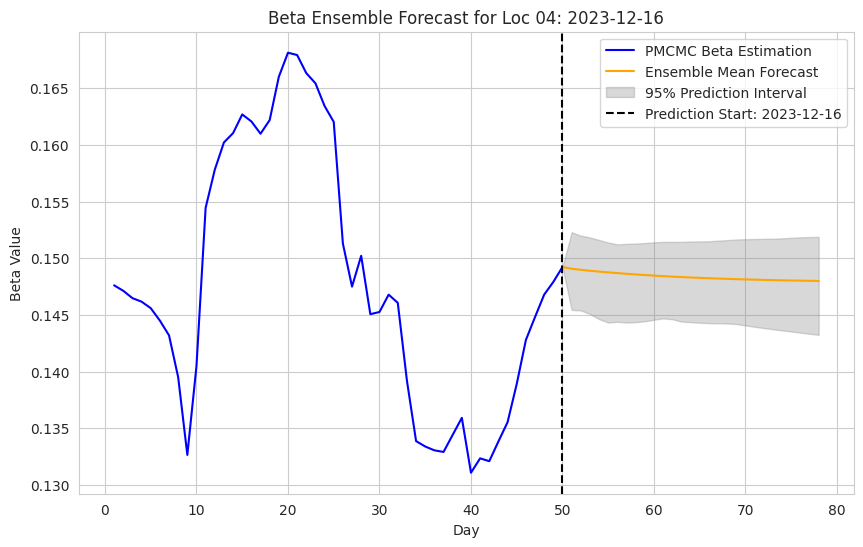

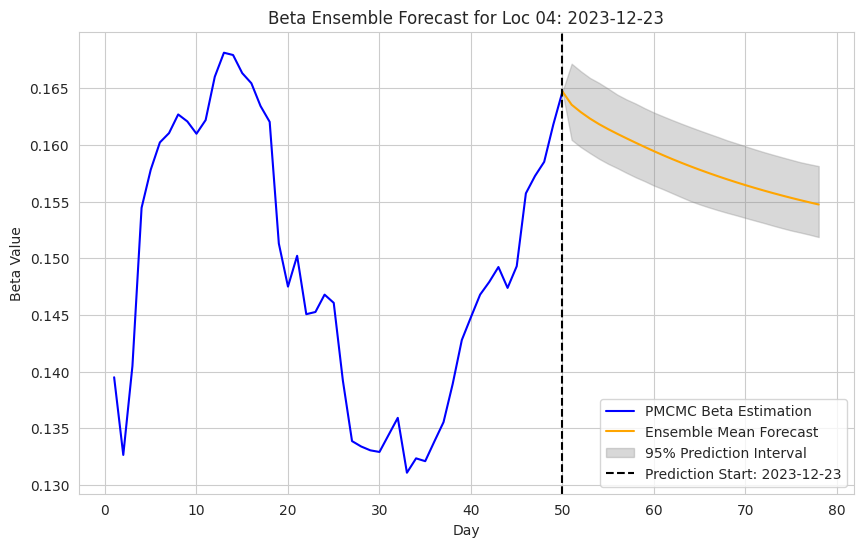

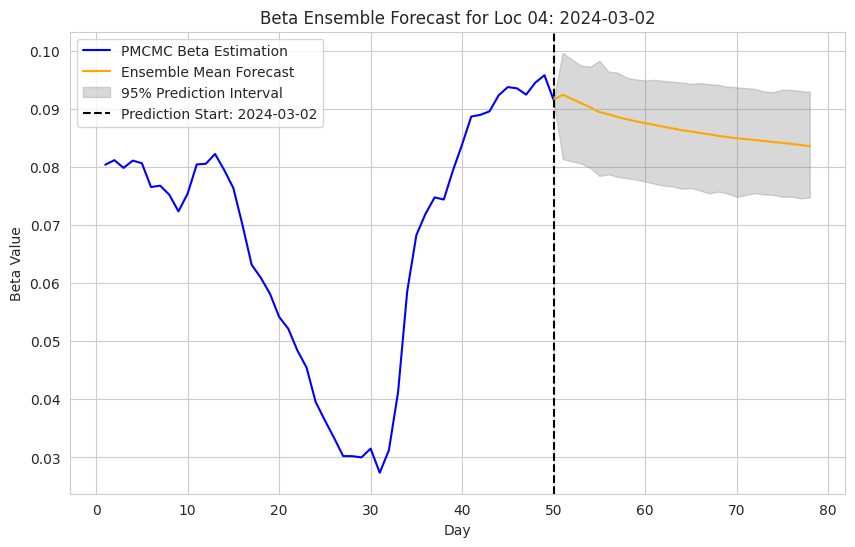

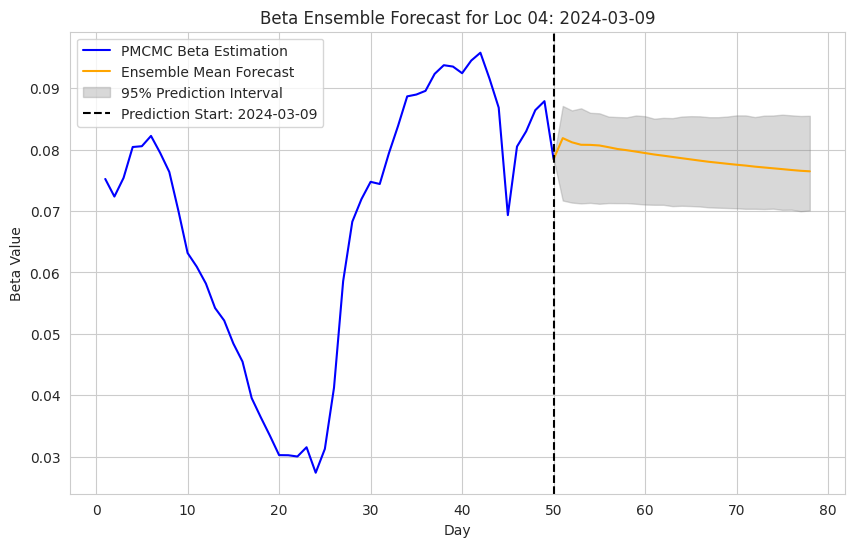

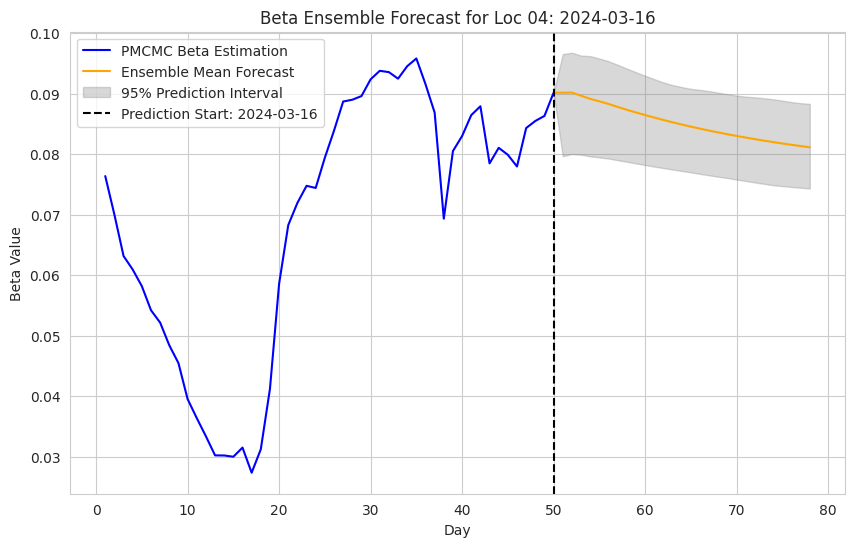

In [28]:
import os

# Plot all data from this test run
for date_folder in os.listdir(paths.TREND_OUTPUT_DIR):
    date_path = os.path.join(paths.TREND_OUTPUT_DIR, date_folder)

    # Check if it is a directory
    if os.path.isdir(date_path):
        ensemble_file = os.path.join(date_path, "ensemble_forecast.csv")

        if os.path.isfile(ensemble_file):
            pmcmc_file_path = os.path.join(paths.PF_OUTPUT_DIR, date_folder, "04.csv")
            plot_beta_forecast(pmcmc_file_path, ensemble_file)
        else:
            print(f"File not found: {ensemble_file}")